# Assignment Chapter 3 - COMPUTER VISION [Case #2]
Startup Campus, Indonesia - `Artificial Intelligence (AI)` (Batch 7)
* Dataset: MNIST Handwritten Digits (10 classes)
* Libraries: PyTorch, Torchvision, Scikit-learn
* Objective: Transfer Learning using CNN-based Pre-trained Models

`PERSYARATAN` Semua modul (termasuk versi yang sesuai) sudah di-install dengan benar.
<br>`CARA PENGERJAAN` Lengkapi baris kode yang ditandai dengan **#TODO**.
<br>`TARGET PORTFOLIO` Peserta mampu:
* mengimplementasikan teknik *transfer learning* dengan berbagai model *pre-trained* dari PyTorch, dan
* menilai efek pembekuan (*freezing*) beberapa bagian dari layer *neural network*.

<br>`PERINGATAN` **DILARANG MENGUBAH** kode yang ada di dalam *user-defined function (UDFs)*.

### Deskripsi
Sebuah fasilitas robot (*robotics facility*) baru yang berlokasi di Kalimantan Timur, dekat Titik Nol Ibu Kota Negara (IKN) Indonesia, meminta Anda untuk membuat model *Computer Vision* untuk produk robot baru mereka. Perusahaan meminta Anda untuk mengajari robot cara membaca rangkaian angka. Anda tiba-tiba menyadari bahwa tahap pertama adalah membiarkan robot mengidentifikasi setiap digit dengan benar (0-9). Namun, karena tanggal pengumuman prototipe dipercepat, *deadline* Anda sangat ketat: Anda hanya memiliki waktu kurang dari 1 minggu untuk menyelesaikan pekerjaan. Sebagai pengembang AI profesional, Anda tetap tenang dan tahu bahwa Anda dapat memanfaatkan metode **Transfer Learning** untuk menyelesaikan masalah ini secara efisien.

Database **Modified National Institute of Standards and Technology (MNIST)** berisi 10 digit tulisan tangan. Semuanya berada dalam skala grayscale (1 channel). Torchvision, sub-library dari PyTorch, memiliki lusinan model terlatih yang dapat Anda pilih dengan mudah. Semua model ini awalnya dilatih pada kumpulan data ImageNet [(ref1)](https://www.image-net.org/download.php), yang berisi jutaan gambar RGB (3 channel) dan 1.000 kelas. Untuk mempermudah, pilihlah **Resnet18** [(ref2)](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf), **DenseNet121** [(ref3)](https://openaccess.thecvf.com/content_cvpr_2017/papers/Huang_Densely_Connected_Convolutional_CVPR_2017_paper.pdf), and **Vision Transformer (ViT)** [(ref4)](https://arxiv.org/pdf/2010.11929.pdf) sebagai model dasar (namun canggih) untuk menguji performa klasifikasi gambar. Sekarang, tugas lengkap Anda adalah sebagai berikut.

1. Pilih DenseNet sebagai model pertama untuk bereksperimen, lalu **ubah jumlah neuron di lapisan pertama dan terakhir** (karena ImageNet memiliki 1.000 kelas, sedangkan MNIST hanya memiliki 10 kelas; keduanya juga memiliki ukuran gambar dan *channel* yang berbeda).
2. Tentukan **hyperparameter** dan latih modelnya (semua layer dilatih dari awal).
3. Plot performa model, baik untuk hasil **pelatihan** maupun **validasi**.
4. Sekarang, coba **bekukan (freeze, tidak dilatih) beberapa bagian dari layer**: (1) "denseblock1", (2) "denseblock1" dan "denseblock2". Ini akan menjadi dua model terpisah.
5. **Latih kembali** (*retrain*) setiap model, visualisasikan performanya, dan periksa perbedaannya.
6. BONUS: Bisakah Anda **mereplikasi** semua langkah di atas dengan model yang berbeda, misalnya **ResNet** dan **ViT**?

### Import libraries

In [ ]:
import torch, torchvision, time
from numpy.random import seed
from tqdm.autonotebook import tqdm
from matplotlib import pyplot as plt
from copy import deepcopy
from warnings import filterwarnings as fw; fw("ignore")

<ipython-input-1-5061f0ddd5d4>:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
torch.__version__ == "2.0.1+cu117"

False

In [ ]:
torchvision.__version__ == "0.15.2+cu117"

False

In [ ]:
# define seeding
seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True

### User-defined Functions (UDFs)

- To print total model parameters

In [ ]:
def check_params(model, *args, **kwargs) -> dict:
    return {
        "total_trainable_params" : sum(p.numel() for p in model.parameters() if p.requires_grad),
        "total_nontrainable_params" : sum(p.numel() for p in model.parameters() if not p.requires_grad)
    }

- To get the pair of train and validation dataloaders

In [ ]:
data_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((torch.tensor(33.3184)/255,), (torch.tensor(78.5675)/255,))
])

train_dataset = torchvision.datasets.MNIST(root=".", train=True, transform=data_transform, download=True).train_data.float()

def get_dataloaders(train_batch_size : int, val_batch_size : int, max_rows : int = 1000, *args, **kwargs) -> tuple:
    data_transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize((224, 224)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((torch.tensor(33.3184)/255,), (torch.tensor(78.5675)/255,))
    ])

    train_dataset = torchvision.datasets.MNIST(root=".", train=True, transform=data_transform)
    train_idx = torch.randperm(len(train_dataset))[:int(max_rows*.75)]
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size, \
                                               sampler=torch.utils.data.SubsetRandomSampler(train_idx))

    val_dataset = torchvision.datasets.MNIST(root=".", train=False, transform=data_transform)
    val_idx = torch.randperm(len(val_dataset))[:int(max_rows*.25)]
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=val_batch_size, \
                                             sampler=torch.utils.data.SubsetRandomSampler(val_idx))

    return train_loader, val_loader

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.59MB/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.09MB/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.17MB/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



* To fit (training) the model

In [ ]:
def fit(
    model : torchvision.models,
    epoch : int,
    train_loader : torch.utils.data.DataLoader,
    val_loader : torch.utils.data.DataLoader,
    *args, **kwargs
) -> dict:

    TRAIN_LOSS, TRAIN_ACC = [], []
    train_batches = len(train_loader)

    VAL_LOSS, VAL_ACC = [], []
    val_batches = len(val_loader)

    # loop for every epoch (training + evaluation)
    start_ts = time.time()
    for e in range(epoch):
        train_losses = 0
        train_accuracies = 0

        # progress bar
        progress = tqdm(enumerate(train_loader), desc="Loss: ", total=train_batches)

        # ----------------- TRAINING  --------------------
        # set model to training
        model.train()

        for i, data in progress:
            X, y = data[0].to(device), data[1].to(device)

            # training step for single batch
            model.zero_grad()

            # forward pass
            outputs = model(X)
            loss = loss_function(outputs, y)

            # backward pass
            loss.backward()
            optimizer.step()

            train_losses += loss.item()

            ps = torch.exp(outputs)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == y.view(*top_class.shape)
            train_accuracies += torch.mean(equals.type(torch.FloatTensor)).item()

            # updating progress bar
            progress.set_description("Loss: {:.4f}".format(train_losses/(i+1)))

        TRAIN_ACC.append(train_accuracies/train_batches)
        TRAIN_LOSS.append(train_losses/train_batches)

        # releasing unceseccary memory in GPU
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        # ----------------- VALIDATION  -----------------
        val_losses = 0
        val_accuracies = 0

        # set model to evaluating (testing)
        model.eval()
        with torch.no_grad():
            for i, data in enumerate(val_loader):
                X, y = data[0].to(device), data[1].to(device)
                outputs = model(X) # this gives the prediction from the network
                val_losses += loss_function(outputs, y).item()

                ps = torch.exp(outputs)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == y.view(*top_class.shape)
                val_accuracies += torch.mean(equals.type(torch.FloatTensor)).item()

        print("Epoch {}/{} >> Training loss: {:.3f}, Validation loss: {:.3f}, Validation accuracy: {:.3f}".format(
            e+1, epoch, train_losses/train_batches, val_losses/val_batches, val_accuracies/val_batches*100)
        )

        VAL_ACC.append(val_accuracies/val_batches)
        VAL_LOSS.append(val_losses/val_batches)

    tr_time = time.time()-start_ts
    print("Training time: {:.3f}s".format(tr_time))

    return {
        "model" : model.name,
        "train_acc" : TRAIN_ACC,
        "train_loss" : TRAIN_LOSS,
        "val_acc" : VAL_ACC,
        "val_loss" : VAL_LOSS,
        "exc_time" : tr_time
    }

* To visualize the model performance

In [ ]:
def plot_performance(dict_ : dict, *args, **kwargs) -> None:
    my_figure = plt.figure(figsize=(12, 4))
    # NOTE: figsize=(width/horizontally, height/vertically)

    m = my_figure.add_subplot(121)
    plt.plot(dict_["train_loss"], label="Train Loss")
    plt.plot(dict_["val_loss"], label="Valid. Loss")
    plt.title("LOSS")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend(loc="best")

    n = my_figure.add_subplot(122)
    plt.plot(dict_["train_acc"], label="Train Accuracy")
    plt.plot(dict_["val_acc"], label="Valid. Accuracy")
    plt.title("ACCURACY")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend(loc="best")

    plt.tight_layout()
    plt.show()

### Define the model class

In [ ]:
class VisionModel(torch.nn.Module):
    def __init__(self, model_selection : str, *args, **kwargs) -> None:
        super(VisionModel, self).__init__()
        self.model_selection = self.name = model_selection
        self.in_channels = 1

        def create_conv2d(this_layer, *args, **kwargs) -> torch.nn.modules.conv.Conv2d:
            return torch.nn.Conv2d(
                in_channels=self.in_channels, out_channels=this_layer.out_channels,
                kernel_size=this_layer.kernel_size, stride=this_layer.stride,
                padding=this_layer.padding, bias=this_layer.bias
            )

        if not self.model_selection.lower() in ["resnet", "densenet", "vit"]:
            raise ValueError("Please select the model: 'resnet', 'densenet', or 'vit'.")

        if self.model_selection == "resnet":
            self.model = torchvision.models.resnet18(pretrained=True)
            self.model.conv1 = create_conv2d(self.model.conv1) # change the input layer to take Grayscale image, instead of RGB
            self.model.fc = torch.nn.Linear(self.model.fc.in_features, 10) # change the output layer to output 10 classes

        elif self.model_selection == "densenet":
          # Muat DenseNet yang telah dilatih sebelumnya dan ubah lapisan input/output
            self.model = torchvision.models.densenet121(pretrained=True)
            self.model.features.conv0 = create_conv2d(self.model.features.conv0) # (DONE) TODO: Ubah susunan input layer DenseNet dengan memanggil create_conv2d()
            self.model.classifier = torch.nn.Linear(self.model.classifier.in_features, 10) # (DONE) TODO: Ubah output layer DenseNet dengan 10 kelas

        elif self.model_selection == "vit":
          # Muat Vision Transformer yang telah dilatih sebelumnya dan modifikasi lapisan input/output
            self.model = torchvision.models.vit_b_16(pretrained=True)
            self.model.conv_proj = torch.nn.Conv2d(1, self.model.conv_proj.out_channels, kernel_size=16, stride=16, bias=False) # (DONE) TODO: TODO: Ubah susunan input layer ViT dengan memanggil create_conv2d()
            self.model.classifier = torch.nn.Linear(self.model.heads.head.in_features, 10) # (DONE) TODO: Ubah output layer ViT dengan 10 kelas

        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, data, *args, **kwargs) -> torchvision.models:
        x = self.model(data)
        return self.softmax(x)

### Set device to CUDA
**PERHATIAN**: Di Google Colab, klik Runtime > Change Runtime Type, lalu pilih **T4 GPU**.

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

### Define hyperparameters

In [ ]:
EPOCH = 5
BATCH_SIZE = 16 # TODO: Tentukan nilai batch size
LEARNING_RATE = 1e-5 # TODO: Tentukan nilai learning rate

### Define the model

In [ ]:
# TODO: Isi parameter dengan "resnet" untuk ResNet18, atau "densenet" untuk DenseNet121, dan "vit" untuk Vision Transformer.
model = VisionModel("resnet").to(device) #bisa menggunakan densenet atau vit
check_params(model)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 200MB/s]


{'total_trainable_params': 11175370, 'total_nontrainable_params': 0}

In [ ]:
model

VisionModel(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

### WILL BE USED LATER: Freeze some layers

In [ ]:
model_freeze_block1 = deepcopy(model)
for name, param in model_freeze_block1.named_parameters():
    if param.requires_grad and "denseblock1" in name:
        param.requires_grad = False
check_params(model_freeze_block1)

{'total_trainable_params': 11175370, 'total_nontrainable_params': 0}

In [ ]:
model_freeze_block12 = deepcopy(model)
for name, param in model_freeze_block12.named_parameters():
    if param.requires_grad and any([x in name for x in ["denseblock1", "denseblock2"]]):
        param.requires_grad = False
check_params(model_freeze_block12)

{'total_trainable_params': 11175370, 'total_nontrainable_params': 0}

### Get train and validation dataloaders

To speedup the training time, we will only use 1,000 (of 60,000) images from MNIST.

In [ ]:
train_loader, val_loader = get_dataloaders(BATCH_SIZE, BATCH_SIZE)
len(train_loader), len(val_loader)

(47, 16)

### Set loss function and model optimizer

In [ ]:
loss_function = torch.nn.CrossEntropyLoss() # Tentukan loss function (untuk multi-classification)

trainable_model_params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(trainable_model_params, lr=LEARNING_RATE)

### Start the model training

In [ ]:
# TODO: Panggil model, lalu tentukan besaran epoch, train data loader, dan validation data loader
results = fit(
    model = model,
    epoch = EPOCH,
    train_loader = train_loader,
    val_loader = val_loader
)

Loss:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 1/5 >> Training loss: 2.237, Validation loss: 2.222, Validation accuracy: 40.859


Loss:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 2/5 >> Training loss: 2.002, Validation loss: 1.908, Validation accuracy: 73.281


Loss:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 3/5 >> Training loss: 1.838, Validation loss: 1.783, Validation accuracy: 81.797


Loss:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 4/5 >> Training loss: 1.729, Validation loss: 1.696, Validation accuracy: 91.953


Loss:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 5/5 >> Training loss: 1.641, Validation loss: 1.624, Validation accuracy: 96.641
Training time: 21.650s


In [ ]:
results

{'model': 'resnet',
 'train_acc': [0.28172492410274264,
  0.6719224922200466,
  0.769566869482081,
  0.8708206681495018,
  0.9574468085106383],
 'train_loss': [2.237486555221233,
  2.002391262257353,
  1.8384708242213472,
  1.729263889028671,
  1.6410267885695113],
 'val_acc': [0.4085937514901161,
  0.7328125014901161,
  0.8179687485098839,
  0.9195312485098839,
  0.9664062485098839],
 'val_loss': [2.222243309020996,
  1.908103734254837,
  1.7832419648766518,
  1.696383886039257,
  1.6235391497612],
 'exc_time': 21.6503643989563}

### Plot the model performance

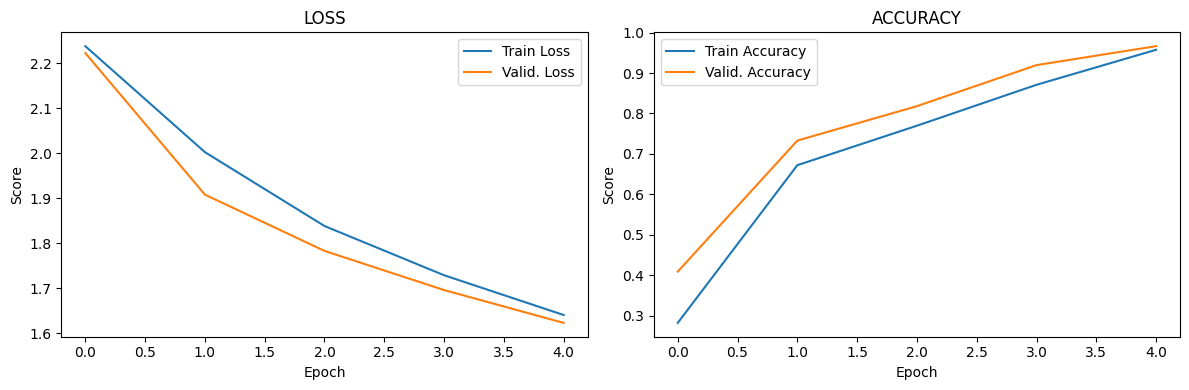

In [ ]:
plot_performance(results)

### NEXT ROUND: Retrain the model with frozen layers

In [ ]:
FROZEN_RESULTS = []
for idx, m in enumerate([model_freeze_block1, model_freeze_block12]):
    print("id: {}".format(idx))
    trainable_model_params = [p for p in m.parameters() if p.requires_grad]
    optimizer = torch.optim.Adam(trainable_model_params, lr=LEARNING_RATE)

    new_results = fit(model=m, epoch=EPOCH, train_loader=train_loader, val_loader=val_loader)
    FROZEN_RESULTS.append(new_results)

id: 0


Loss:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 1/5 >> Training loss: 2.235, Validation loss: 2.215, Validation accuracy: 45.391


Loss:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 2/5 >> Training loss: 2.007, Validation loss: 1.911, Validation accuracy: 76.094


Loss:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 3/5 >> Training loss: 1.837, Validation loss: 1.781, Validation accuracy: 83.125


Loss:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 4/5 >> Training loss: 1.728, Validation loss: 1.694, Validation accuracy: 90.938


Loss:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 5/5 >> Training loss: 1.633, Validation loss: 1.621, Validation accuracy: 96.641
Training time: 20.686s
id: 1


Loss:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 1/5 >> Training loss: 2.232, Validation loss: 2.218, Validation accuracy: 40.547


Loss:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 2/5 >> Training loss: 2.004, Validation loss: 1.910, Validation accuracy: 73.906


Loss:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 3/5 >> Training loss: 1.833, Validation loss: 1.782, Validation accuracy: 80.625


Loss:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 4/5 >> Training loss: 1.725, Validation loss: 1.687, Validation accuracy: 92.578


Loss:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 5/5 >> Training loss: 1.633, Validation loss: 1.615, Validation accuracy: 96.641
Training time: 20.242s


### Examine the difference in both accuracy and loss

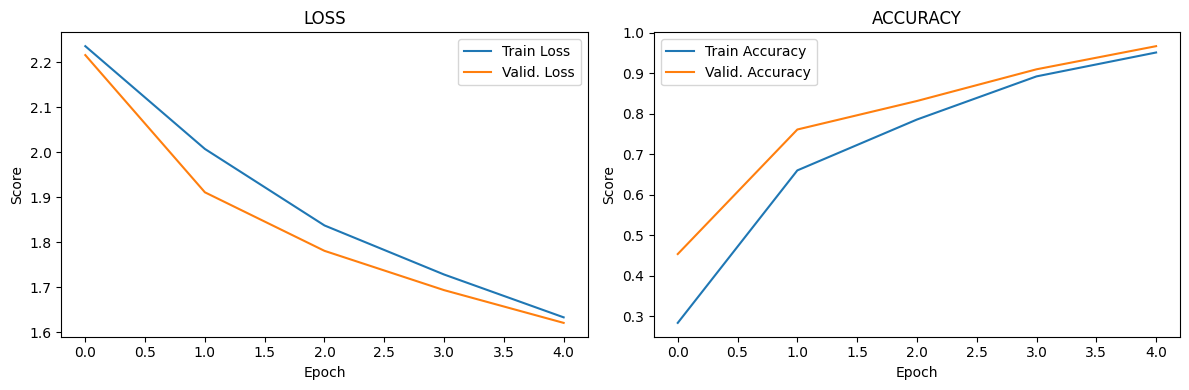

In [ ]:
plot_performance(FROZEN_RESULTS[0])

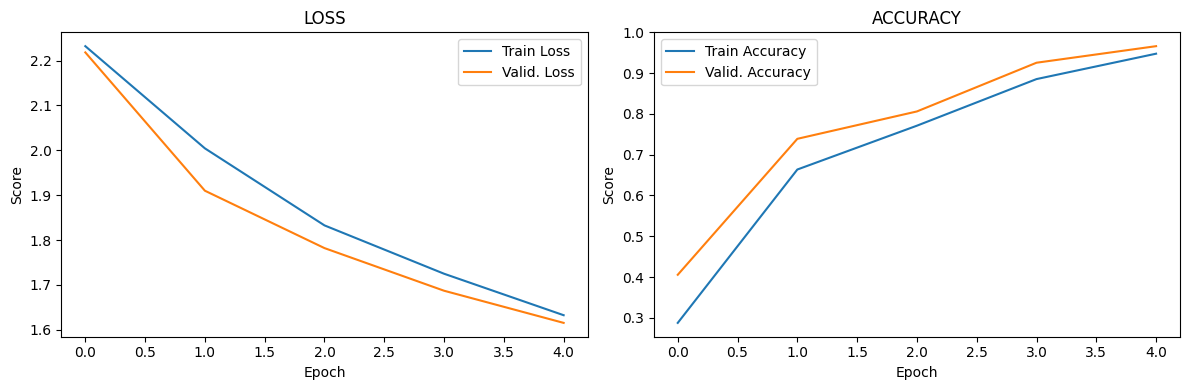

In [ ]:
plot_performance(FROZEN_RESULTS[1])

In [ ]:
# [ PERTANYAAN ]
# TODO: Dengan 5 iterasi yang sama pada training, mengapa Transfer Learning dengan layer yang di-freeze lebih buruk di akurasi akhir?

Transfer Learning dengan layer yang di-freeze lebih buruk di akurasi akhir, karena:

1. Ketidakcocokan Domain: Model yang dilatih di domain berbeda mungkin tidak mengekstrak fitur relevan untuk tugas baru.
2. Overfitting: Model dengan kapasitas tinggi dan data terbatas bisa terlalu cocok dengan set pelatihan.
3. Batasan Ekstraksi Fitur: Fitur yang dibekukan mungkin tidak sesuai untuk masalah spesifik, menghambat pembelajaran.
4. Sensitivitas Kecepatan Pembelajaran: Kecepatan pembelajaran yang tidak tepat dapat menyebabkan ketidakstabilan atau pelatihan tidak memadaai
5. Pelatihan Tidak Memadai: Lima epoch mungkin tidak cukup untuk menyempurnakan lapisan, menghambat penyesuaian bobot.

In [ ]:
# [ PERTANYAAN ]
# TODO: Mengapa semakin banyak layer yang di-freeze, semakin rendah akurasi model di awal iterasi (epoch)?

Semakin banyak layer yang di-freeze, semakin rendah akurasi model di awal iterasi (epoch), itu disebabkan karena:

- Dinamika Pembelajaran: Dengan lebih sedikit lapisan yang dapat dilatih, lapisan yang tersisa harus mengekstrak fitur tanpa modifikasi representasi yang lebih dalam, menyulitkan proses belajar.
- Ketidakcocokan Representasi Fitur: Fitur dari lapisan beku mungkin tidak relevan untuk tugas baru, seperti klasifikasi digit MNIST.
Masalah Aliran Gradien: Membekukan banyak lapisan dapat mengganggu aliran gradien, menyulitkan pembelajaran.
- Masalah Inisialisasi: Lapisan yang tidak dibekukan mulai dari bobot yang mungkin tidak sesuai, mengakibatkan kerugian dan akurasi rendah di awal pelatihan.
- Kemampuan Beradaptasi Terbatas: Membekukan lapisan menghambat model untuk menyesuaikan ekstraksi fitur dengan kumpulan data baru, terutama jika domainnya berbeda, sehingga performa awal rendah.
- Risiko Overfitting: Banyak lapisan yang dibekukan meningkatkan risiko model terlalu cocok dengan data pelatihan.

### Examine the difference in the execution time

In [ ]:
print("When all layers were TRAINABLE: {:.3f}s.".format(results["exc_time"]))
print("Only 'denseblock1' was FROZEN: {:.3f}s.".format(FROZEN_RESULTS[0]["exc_time"]))
print("Only 'denseblock1' and 'denseblock2' wwere FROZEN: {:.3f}s.".format(FROZEN_RESULTS[1]["exc_time"]))

When all layers were TRAINABLE: 21.650s.
Only 'denseblock1' was FROZEN: 20.686s.
Only 'denseblock1' and 'denseblock2' wwere FROZEN: 20.242s.


In [ ]:
# [ PERTANYAAN ]
# TODO: Mengapa semakin banyak layer yang di-freeze, semakin cepat waktu training dan validasinya?

Semakin banyak layer yang di-freeze, semakin cepat waktu training dan validasinya disebabkan karena:

- Pengurangan Perhitungan Gradien: Layer yang di-freeze tidak memerlukan perhitungan gradien, mengurangi beban komputasi pada backpropagation.
- Pengurangan Update Bobot: Layer yang di-freeze tidak mengalami update parameter, mempercepat proses optimisasi.
- Validasi Lebih Cepat: Validasi hanya melalui forward pass, tanpa perhitungan gradien atau update bobot.
- Forward Pass Lebih Sederhana: Layer yang di-freeze hanya memproses input tanpa memperhitungkan perubahan bobot, sehingga lebih efisien.
- Penggunaan Memori Rendah: Layer yang di-freeze tidak menyimpan gradien atau cache aktivasi, mengurangi beban memori GPU.


### Scoring
Total `#TODO` = 12
<br>Checklist:

- [✔] Ubah susunan input layer DenseNet dengan memanggil create_conv2d()
- [✔] Ubah output layer DenseNet dengan 10 kelas
- [✔] Ubah susunan input layer ViT dengan memanggil create_conv2d()
- [✔] Ubah output layer ViT dengan 10 kelas
- [✔] Tentukan nilai batch size
- [✔] Tentukan nilai learning rate
- [✔] Tentukan loss function (untuk multi-classification)
- [✔] Isi parameter dengan "resnet" untuk ResNet18, atau "densenet" untuk DenseNet121, dan "vit" untuk Vision Transformer.
- [✔] Panggil model, lalu tentukan besaran epoch, train data loader, dan validation data loader
- [✔] PERTANYAAN: Dengan 5 iterasi yang sama pada training, mengapa Transfer Learning dengan layer yang di-freeze lebih buruk di akurasi akhir?
- [✔] PERTANYAAN: Mengapa semakin banyak layer yang di-freeze, semakin rendah akurasi model di awal iterasi (epoch)?
- [✔] PERTANYAAN: Mengapa semakin banyak layer yang di-freeze, semakin cepat waktu training dan validasinya?

### Additional readings
* ResNet: https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf
* DenseNet: https://openaccess.thecvf.com/content_cvpr_2017/papers/Huang_Densely_Connected_Convolutional_CVPR_2017_paper.pdf
* Vision Transformer (ViT): https://arxiv.org/pdf/2010.11929.pdf
* MNIST Classification w/ PyTorch (Beginner): https://www.kaggle.com/code/amsharma7/mnist-pytorch-for-beginners-detailed-desc

### Copyright © 2024 Startup Campus, Indonesia
* Prepared by **Nicholas Dominic, M.Kom.** [(profile)](https://linkedin.com/in/nicholas-dominic)
* You may **NOT** use this file except there is written permission from PT. Kampus Merdeka Belajar (Startup Campus).
* Please address your questions to mentors.